In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def detect_stage_lights(image_path, top_n=100, region_size=20, n_clusters=5):
    # 画像を読み込む
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("画像を読み込めませんでした。パスを確認してください。")

    # 輝度検出のためにグレースケールに変換
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 最も明るい top_n ピクセルのインデックスを取得
    flat_gray = gray.flatten()
    indices = np.argpartition(flat_gray, -top_n)[-top_n:]
    h, w = gray.shape
    points = np.array([(idx % w, idx // w) for idx in indices])

    # 各明るい点の周囲の領域から平均RGBを計算
    colors = []
    coords = []

    for x, y in points:
        x1, x2 = max(x - region_size//2, 0), min(x + region_size//2, w)
        y1, y2 = max(y - region_size//2, 0), min(y + region_size//2, h)
        patch = image[y1:y2, x1:x2]
        avg_bgr = np.mean(patch, axis=(0, 1))
        avg_rgb = avg_bgr[::-1]  # BGR → RGB に変換
        colors.append(avg_rgb)
        coords.append((x, y))

    colors = np.array(colors)

    # 色をクラスタリングして類似のライト色をまとめる
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(colors)

    # 検出された座標に矩形を描画（各クラスタごとに平均色を使用）
    for i, (x, y) in enumerate(coords):
        color = tuple(int(c) for c in kmeans.cluster_centers_[labels[i]])
        color_bgr = color[::-1]  # RGB → BGR（OpenCV用）
        cv2.rectangle(image, (x - 10, y - 10), (x + 10, y + 10), color_bgr, 2)

    # 各クラスタの平均色を出力
    print("検出されたライトの色（RGB）:")
    rgb_colors = []
    label_names = []

    for i, center in enumerate(kmeans.cluster_centers_):
        rgb = center.astype(int)
        rgb_colors.append(rgb / 255.0)  # matplotlib 用に正規化
        label_names.append(f"Light #{i+1}")
        print(f"{label_names[-1]}: {rgb}")

    # 検出したライトの位置を表示（矩形付き画像）
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title("Detected Bright Areas")
    plt.axis("off")
    plt.show()

    # 色のブロックを並べて可視化
    fig, ax = plt.subplots(figsize=(1.8 * n_clusters, 2))
    for i, color in enumerate(rgb_colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
        ax.text(i + 0.5, -0.3, label_names[i], ha='center', va='top', fontsize=12)

    ax.set_xlim(0, len(rgb_colors))
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title("Detected Light Colors", fontsize=14)
    plt.show()

    return kmeans.cluster_centers_.astype(int)


検出されたライトの色（RGB）:
Light #1: [234 191 209]
Light #2: [251 240 240]
Light #3: [158 108 185]
Light #4: [105  40  66]
Light #5: [202 150 246]
Light #6: [234 203 240]


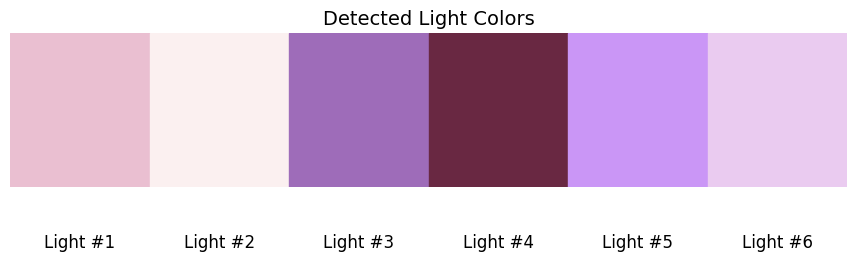

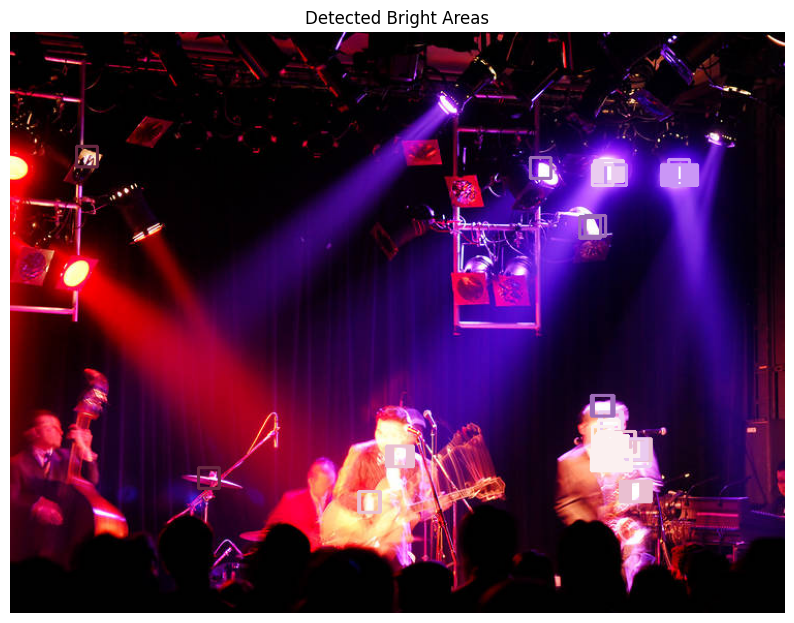

array([[234, 191, 209],
       [251, 240, 240],
       [158, 108, 185],
       [105,  40,  66],
       [202, 150, 246],
       [234, 203, 240]])

In [ ]:
detect_stage_lights("/content/111.jpg", top_n=150, region_size=30, n_clusters=6)